In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
import warnings; warnings.simplefilter('ignore')

In [4]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set

### Collect data

In [5]:
DATASET_ID = 'BIRD_DB_Toxostoma_redivivum_segmented'

In [6]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [7]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'thrasher.pickle'
df_loc

PosixPath('/local/home/tsainbur/github_repos/avgn_paper/data/syllable_dfs/BIRD_DB_Toxostoma_redivivum_segmented/thrasher.pickle')

In [8]:
syllable_df = pd.read_pickle(df_loc)

In [9]:
syllable_df[:3]

start_time    end_time        indv  indvi label  \
0   24.452796   24.545296    CATH-CP1      0   nhv   
0  388.917194  389.066694   CATH-TLR8      0   avb   
0   50.144617   50.266617  CATH-TLR12      0   anj   

                                key   rate  \
0   2009-03-21_08-44-00-000000_1669  44100   
0  2012-03-29_07-55-00-000000_13484  44100   
0  2012-03-27_08-12-00-000000_11234  44100   

                                         spectrogram  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

In [12]:
pd.DataFrame({i:[sum(syllable_df.label == i)] for i in syllable_df.label.unique()}).T.sort_values(by=0, ascending=False).T

nct  aut  nfo  aiz  alc  acb  arp  aqh  ngs  ncr  ...  nez  bbi  akl  nih  \
0  227  218  198  189  163  163  161  160  159  158  ...    1    1    1    1   

   nhl  avp  azr  agd  nfv  bbm  
0    1    1    1    1    1    1  

[1 rows x 878 columns]

In [13]:
len(syllable_df)

20568

Text(0.5, 1.0, 'min')

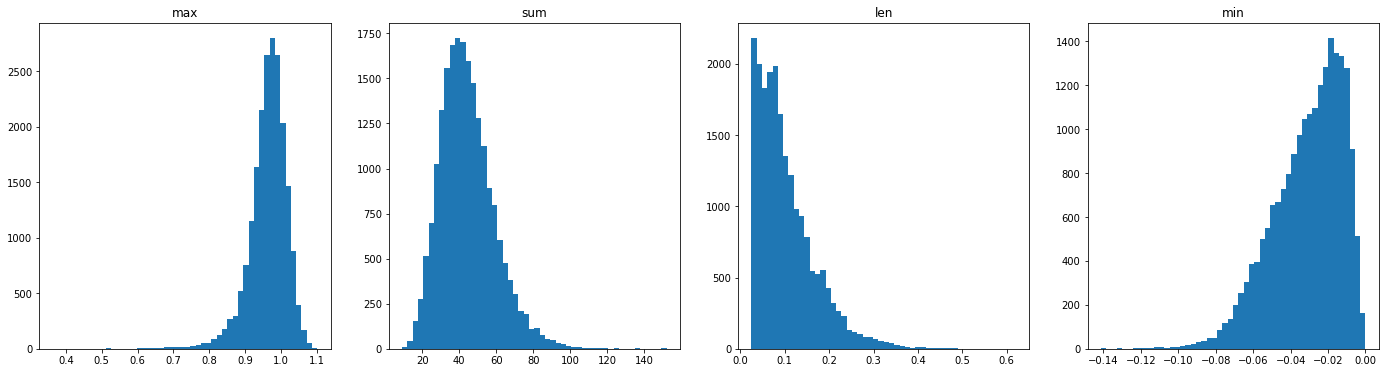

In [14]:
fig, axs = plt.subplots(ncols=4, figsize=(24,6))
axs[0].hist([np.max(i) for i in syllable_df.spectrogram.values], bins=50);axs[0].set_title('max')
axs[1].hist([np.sum(i) for i in syllable_df.spectrogram.values], bins=50);axs[1].set_title('sum')
axs[2].hist((syllable_df.end_time - syllable_df.start_time).values, bins = 50); axs[2].set_title('len')
axs[3].hist([np.min(i) for i in syllable_df.spectrogram.values], bins=50);axs[3].set_title('min')

### cluster

In [15]:
len(syllable_df)

20568

In [16]:
def norm(x):
    return (x-np.min(x)) / (np.max(x) - np.min(x))

In [17]:
specs = list(syllable_df.spectrogram.values)
specs = [norm(i) for i in specs]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(20568, 704)

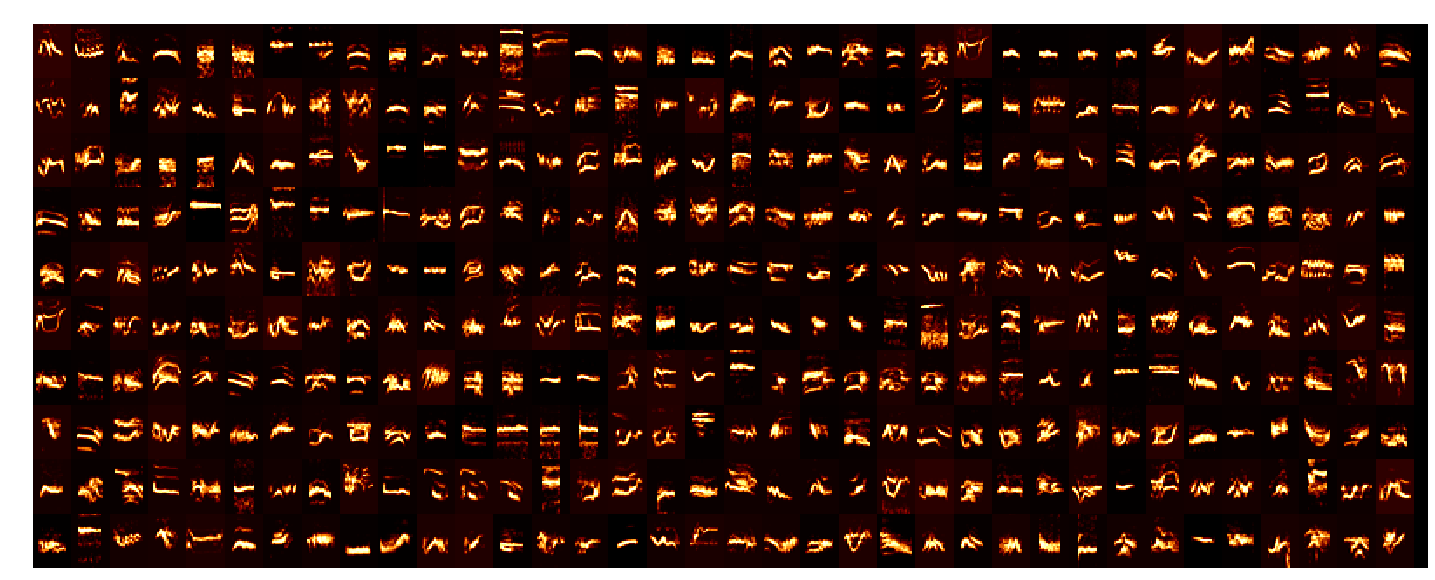

In [18]:
draw_spec_set(specs, zoom=1, maxrows=10, colsize=25)

### cluster

In [20]:
from cuml.manifold.umap import UMAP as cumlUMAP

In [28]:
cuml_umap = cumlUMAP()#min_dist=0.25)
embedding = cuml_umap.fit_transform(specs_flattened)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  


In [29]:
#fit = umap.UMAP(min_dist=0.25)

In [30]:
np.shape(specs_flattened)

(20568, 704)

In [31]:
z  = list(embedding)
z = np.vstack(z)

(-5, 5)

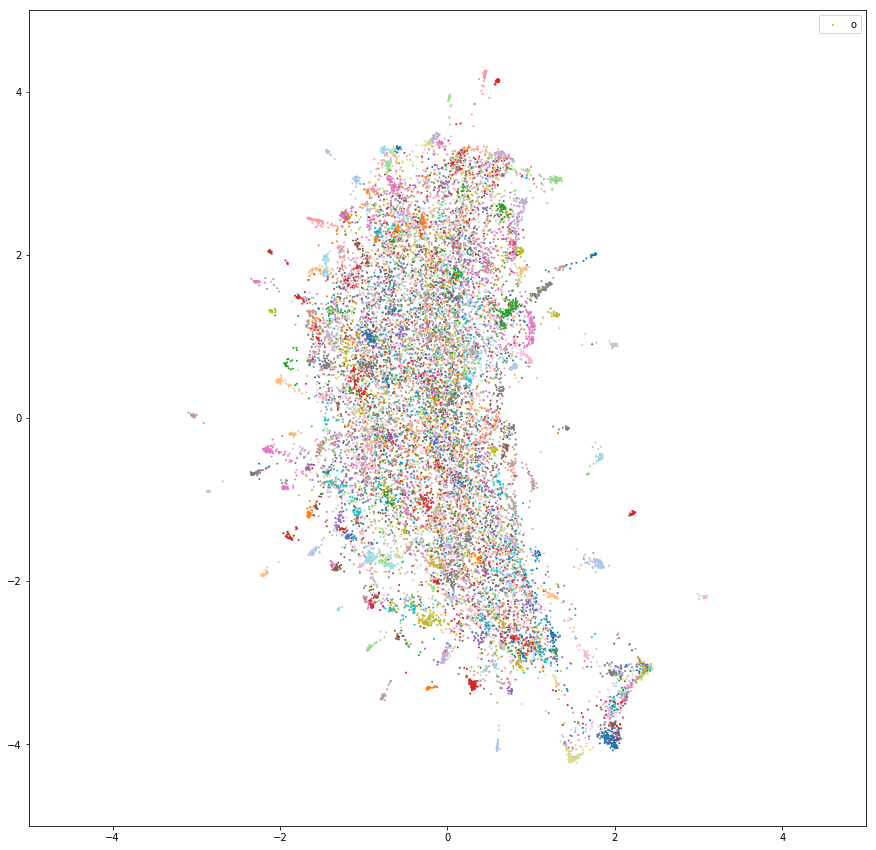

In [32]:
fig, ax = plt.subplots(figsize=(15, 15))
#scatter_projections(projection=z, alpha=0.05, labels=None, s=5, ax=ax)
scatter_projections(
    projection=z,
    alpha=1,
    labels=syllable_df.label.values,
    s=1,
    ax=ax,
)
ax.legend('off')
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])

In [24]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

In [30]:
len(mask), len(syllable_df), len(z)

(407642, 407642, 407642)

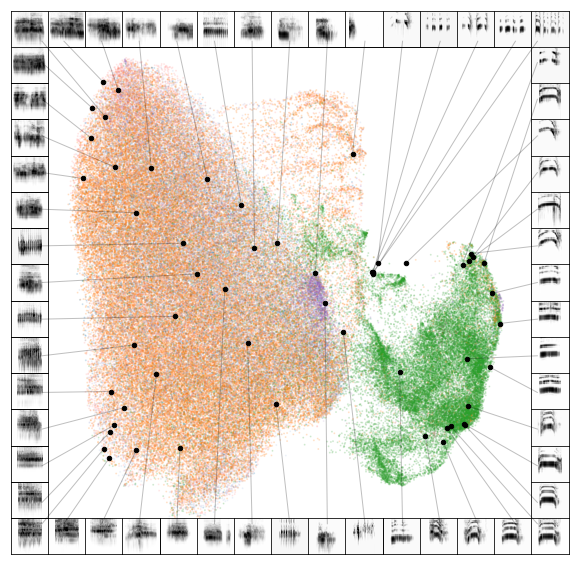

In [34]:
scatter_spec(
    z[mask],
    np.array(specs)[mask],
    column_size=15,
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        'labels': syllable_df[mask].context.values,
        'alpha':0.15,
        's': 1,
        'show_legend': False,
        'color_palette': 'tab20'
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True
);
save_fig(FIGURE_DIR / 'cassins-segmented', dpi=300, save_jpg=True)

In [50]:
pd.DataFrame({i:[sum(syllable_df.indv == i)] for i in syllable_df.indv.unique()}).T.sort_values(by=0, ascending=False).T

0   -215   -231    215    230   -216    231    226   -211    228  ...  \
0  38099  26719  23437  21880  17488  17238  14726  13083  12188  12100  ...   

   -118  218  118  -223  105  223  103  -105  -108  -113  
0   385  312  311   300  287  251  235   222   203    23  

[1 rows x 83 columns]

(-5, 5)

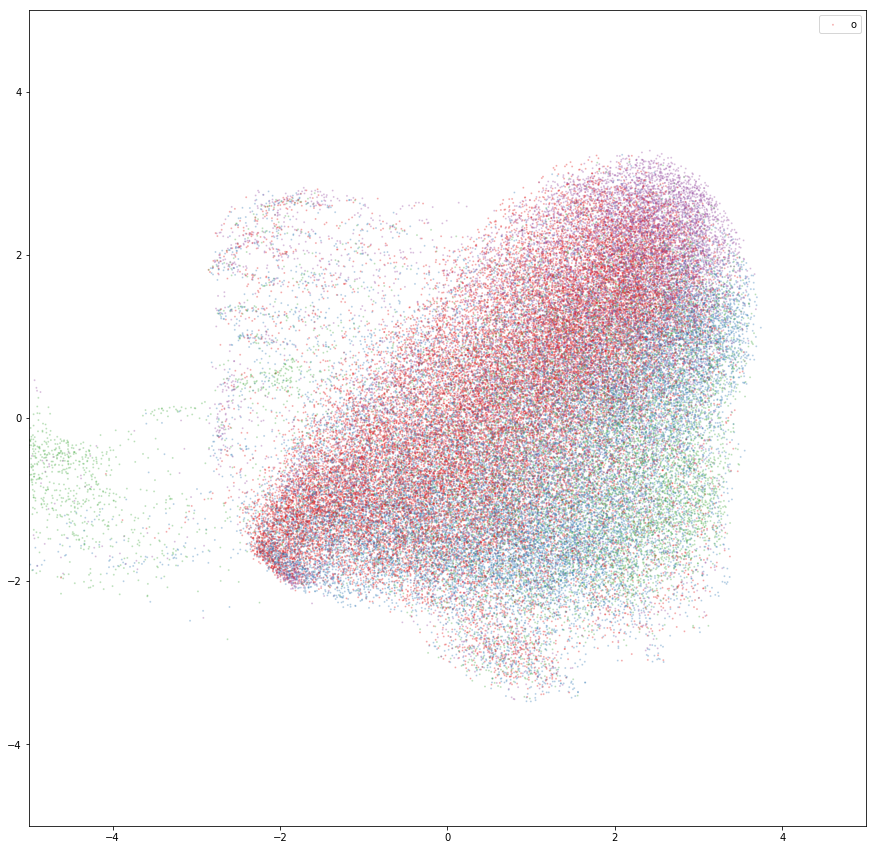

In [51]:
mask = syllable_df.indv.isin(['-215', '-231', '216', '226'])
fig, ax = plt.subplots(figsize=(15, 15))
scatter_projections(
    projection=z[mask],
    alpha=0.25,
    labels=syllable_df[mask].indv.values,
    color_palette = 'Set1',
    s=1,
    ax=ax,
)
ax.legend('off')
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])

In [25]:
specs = list(syllable_df.spectrogram.values)
specs = [norm(i) for i in specs]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)
mask = syllable_df.context.isin(["General", 'Sleeping', 'Unknown']) == False
specs_flattened = specs_flattened[mask]
cuml_umap = cumlUMAP()
embedding_mask = cuml_umap.fit_transform(specs_flattened)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  import sys
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  


(-5, 5)

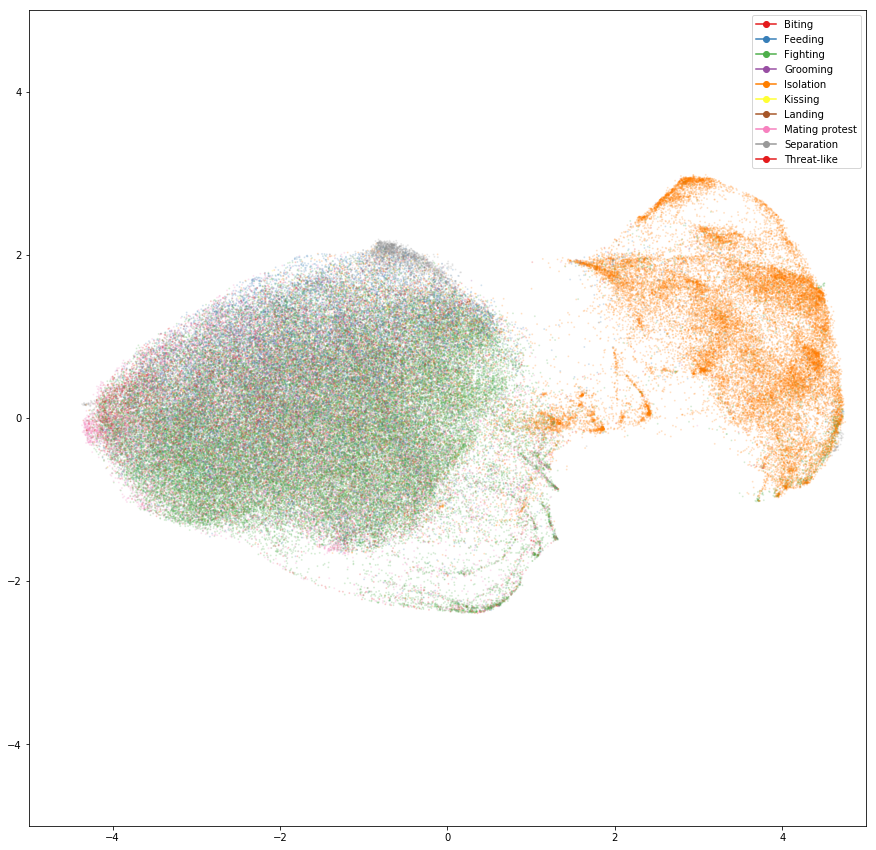

In [28]:
fig, ax = plt.subplots(figsize=(15, 15))
#scatter_projections(projection=z, alpha=0.05, labels=None, s=5, ax=ax)
scatter_projections(
    projection=embedding_mask,
    alpha=0.15,
    labels=syllable_df[mask].context.values,
    color_palette = 'Set1',
    s=1,
    ax=ax,
)
#ax.legend('off')
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])

In [29]:
pd.DataFrame({i:[sum(syllable_df.context == i)] for i in syllable_df.context.unique()}).T.sort_values(by=0, ascending=False).T

Sleeping  General  Fighting  Isolation  Feeding  Mating protest  \
0    133168   125411     57630      33826    20265           16832   

   Threat-like  Biting  Separation  Unknown  Grooming  Kissing  Landing  
0         6578    5717        2950     2780      1483      973       29

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  import sys
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  


(-5, 5)

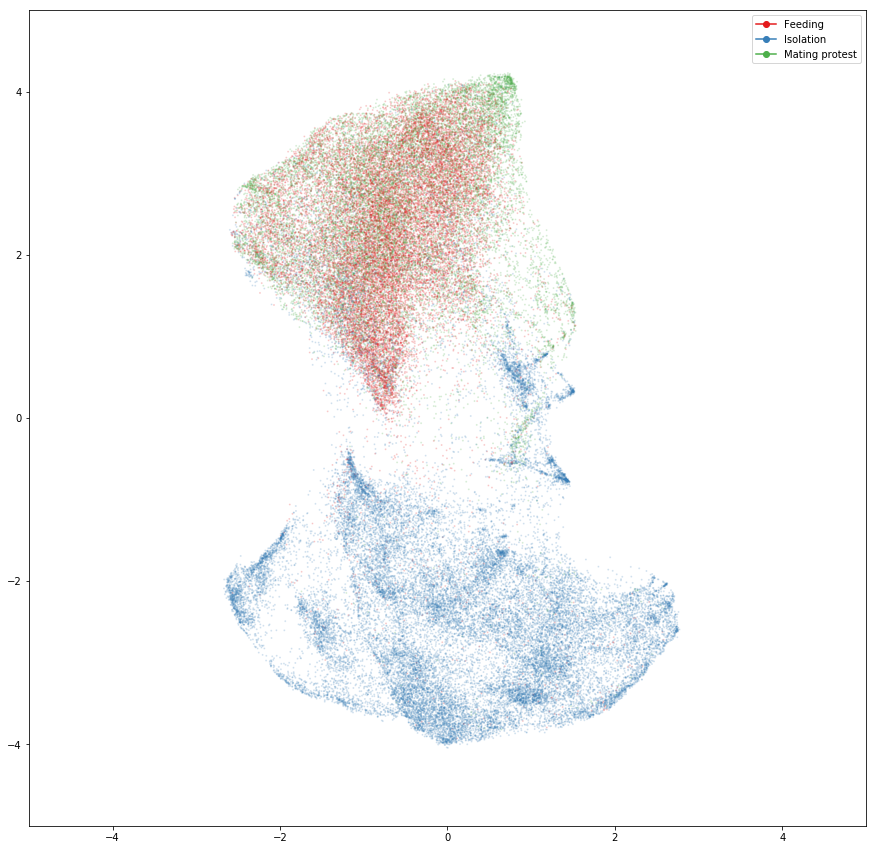

In [30]:
specs = list(syllable_df.spectrogram.values)
specs = [norm(i) for i in specs]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)
mask = syllable_df.context.isin(["Isolation", 'Mating protest', 'Feeding'])# == False
specs_flattened = specs_flattened[mask]
cuml_umap = cumlUMAP()
embedding_mask = cuml_umap.fit_transform(specs_flattened)

fig, ax = plt.subplots(figsize=(15, 15))
#scatter_projections(projection=z, alpha=0.05, labels=None, s=5, ax=ax)
scatter_projections(
    projection=embedding_mask,
    alpha=0.15,
    labels=syllable_df[mask].context.values,
    color_palette = 'Set1',
    s=1,
    ax=ax,
)
#ax.legend('off')
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  import sys
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  


(-5, 5)

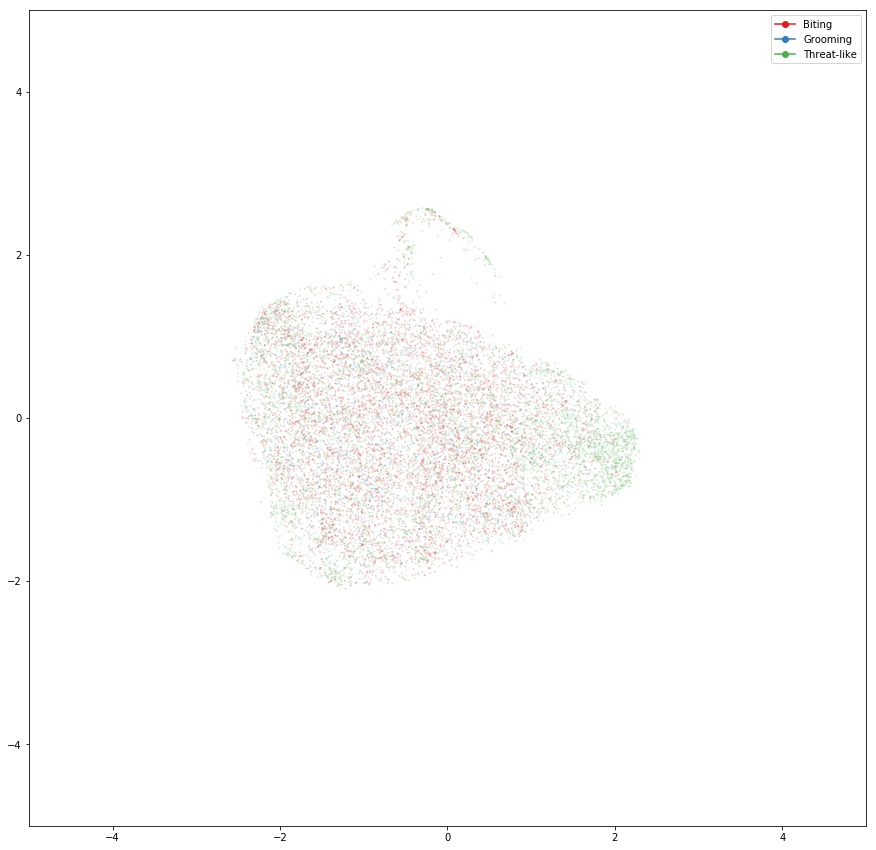

In [32]:
specs = list(syllable_df.spectrogram.values)
specs = [norm(i) for i in specs]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)
mask = syllable_df.context.isin(["Grooming", 'Threat-like', 'Biting'])# == False
specs_flattened = specs_flattened[mask]
cuml_umap = cumlUMAP()
embedding_mask = cuml_umap.fit_transform(specs_flattened)

fig, ax = plt.subplots(figsize=(15, 15))
#scatter_projections(projection=z, alpha=0.05, labels=None, s=5, ax=ax)
scatter_projections(
    projection=embedding_mask,
    alpha=0.15,
    labels=syllable_df[mask].context.values,
    color_palette = 'Set1',
    s=1,
    ax=ax,
)
#ax.legend('off')
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])

In [61]:
syllable_df[syllable_df.indv.values.astype('int') < 0] = syllable_df[syllable_df.indv.values.astype('int') < 0] * -1

In [63]:
syllable_df[:3]

start_time  end_time indv  indvi context key    rate  \
0      -0.203   -0.2790           0             -250000   
1      -0.372   -0.5065           0             -250000   
0      -0.223   -0.2465           0             -250000   

                                         spectrogram  
0  [[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...  
1  [[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...  
0  [[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...

In [64]:
indv_df = pd.DataFrame({i:[sum(syllable_df.indv == i)] for i in syllable_df.indv.unique()}).T.sort_values(by=0, ascending=False).T
indv_df

0    215    230    231    226    228    216   213   211  ...  \
0  198169  38099  21880  17488  14726  13083  12100  10018  7946  6327  ...   

   233  113  101  116  214  218  118  105  223  103  
0  771  765  710  537  483  312  311  287  251  235  

[1 rows x 43 columns]

In [73]:
indvs = list(indv_df.columns[2:12])
indvs

['215', '230', '231', '226', '228', '216', '213', '211', '204', '111']

In [74]:
specs = list(syllable_df.spectrogram.values)
specs = [norm(i) for i in specs]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)
mask = syllable_df.indv.isin(indvs)# == False
specs_flattened = specs_flattened[mask]
cuml_umap = cumlUMAP()
embedding_mask = cuml_umap.fit_transform(specs_flattened)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  import sys
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  


(-5, 5)

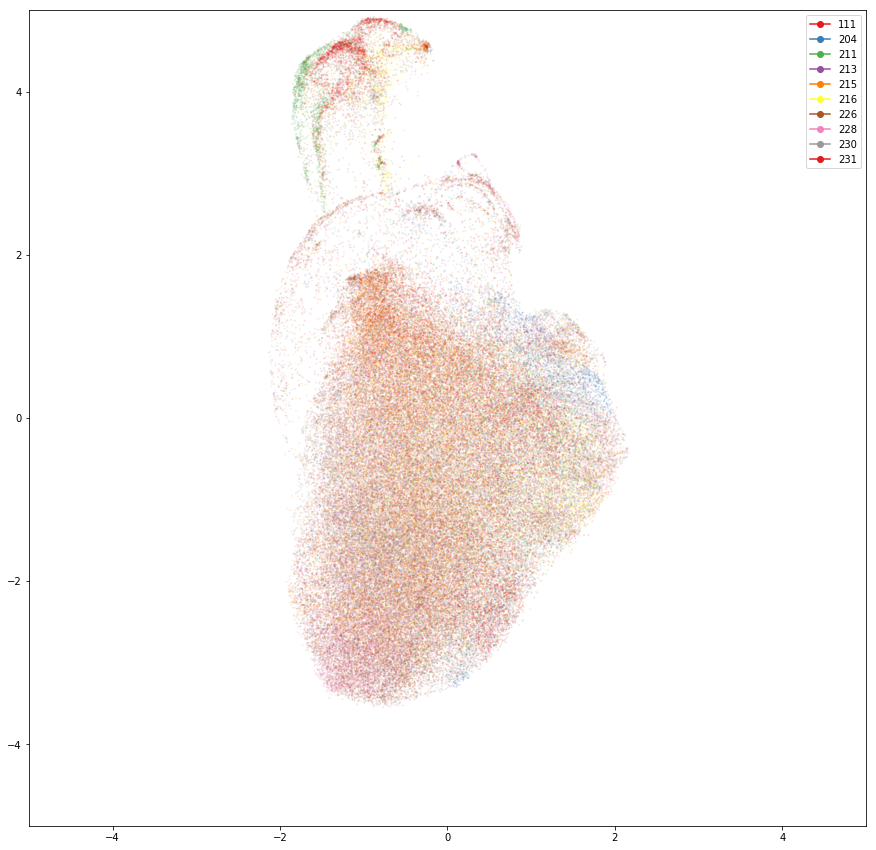

In [78]:
fig, ax = plt.subplots(figsize=(15, 15))
scatter_projections(
    projection=embedding_mask,
    alpha=0.1,
    labels=syllable_df[mask].indv.values,
    color_palette = 'Set1',
    s=1,
    ax=ax,
)
#ax.legend('off')
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])